In [3]:
from skimage import io, color
from skimage.morphology import binary_closing, binary_opening
from skimage.morphology import disk
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from skimage.color import label2rgb
import pydicom as dicom
from scipy.stats import norm
from scipy.spatial import distance
import os
import pandas as pd
import seaborn as sns
from scipy.stats import lognorm
import statsmodels.api as sm
from scipy.stats import shapiro
from functools import reduce
from tqdm import tqdm
import math


def show_comparison(original, modified, modified_name, fig_title : str = ""):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    fig.suptitle(fig_title)
    ax1.imshow(original, cmap="gray", vmin=-200, vmax=500)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified)
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()
    
def plot_comparison(original, filtered, filter_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')
    io.show()
    
def get_segment(segment_name):
    path = os.path.join(BASEDIR, segment_name)
    segment = io.imread(path)
    segment_mask = segment > 0
    segment_values = img[segment_mask]
    return segment, segment_values

def analyse_segment(segment_values, segment_name, ax=None):
    statistic_data = segment_values.flatten()
    stats = pd.DataFrame(statistic_data, columns=[segment_name]).describe()
    sns.histplot(statistic_data, kde=True, ax=ax)
    if ax:
        ax.set_xlabel('Hounsfield unit')
        ax.set_ylabel('Frequency')
        ax.set_title(f"{segment_name} values in CT scan")
    else:
        plt.title(f"{segment_name} values in CT scan")
        plt.show()
    return statistic_data, stats


def fitted_gaussian(statistic_data, name, ax = None):
    mu, std = norm.fit(statistic_data)
    n_bins = 60
    if ax:
        n, bins, patches = ax.hist(statistic_data, n_bins, density=1)
        pdf_spleen = norm.pdf(bins, mu, std)
        ax.plot(bins, pdf_spleen)
        ax.set_xlabel('Hounsfield unit')
        ax.set_ylabel('Frequency')
        ax.set_title(f"{name} values in CT scan")
    else:
        n, bins, patches = plt.hist(statistic_data, n_bins, density=1)
        pdf_spleen = norm.pdf(bins, mu, std)
        plt.plot(bins, pdf_spleen)
        plt.xlabel('Hounsfield unit')
        plt.ylabel('Frequency')
        plt.title(f"{name} values in CT scan")
        plt.show()
    
def QQ_plot(statistic_data, name, ax=None):
    sm.qqplot(statistic_data, line='45', ax=ax)
    if ax:
        ax.set_title(f"QQ-plot of {name} values")
    else:
        plt.title(f"QQ-plot of {name} values")
        plt.show()

def shapiro_wilk_test(statistic_data, name):
    stat, p = shapiro(statistic_data)
    print(f"Shapiro-Wilk test for {name} yields p-value of : {p}\nstatistic: {stat}")
    if p > 0.05:
        print("Sample looks Gaussian (fail to reject H0)")
    else:
        print("Sample does not look Gaussian (reject H0)")

def boxplot(statistic_data, name, ax=None):
    sns.boxplot(x=statistic_data, ax=ax)
    if ax:
        ax.set_title(f"Boxplot of {name} values")
    else:
        plt.title(f"Boxplot of {name} values")
        plt.show()
    
def merge_df(df1, df2):
    return pd.merge(df1, df2, left_index=True, right_index=True)

def merge_dfs(dfs):
    return reduce(merge_df, dfs)

def get_class_boundaries_by_median(class_stats):
    # Sort classes by mean
    order = class_stats.median().sort_values()

    boundaries = []

    bg_threshold = -200

    # Get index of order
    for idx, name in enumerate(order.index):
        # [Name, min, max]
        if idx == 0:
            b_min = bg_threshold
            
            next_name = order.index[idx + 1]
            next_min = class_stats.loc["min", next_name]
            b_max = (next_min + class_stats.loc["max", name]) / 2
        elif idx == len(order.index) - 1:
            b_max = float("inf")
            
            prev_name = order.index[idx - 1]
            prev_max = class_stats.loc["max", prev_name]
            b_min = (prev_max + class_stats.loc["min", name]) / 2
        else:
            prev_name = order.index[idx - 1]
            next_name = order.index[idx + 1]
            prev_max = class_stats.loc["max", prev_name]
            next_min = class_stats.loc["min", next_name]
            
            b_min = (prev_max + class_stats.loc["min", name]) / 2
            b_max = (next_min + class_stats.loc["max", name]) / 2
        boundaries.append([name, b_min, b_max])
    return boundaries

def get_class_boundaries_by_mean(class_stats):
    # Sort classes by mean
    order = class_stats.mean().sort_values()

    boundaries = []

    bg_threshold = -200

    # Get index of order
    for idx, name in enumerate(order.index):
        # [Name, min, max]
        if idx == 0:
            b_min = bg_threshold
            
            next_name = order.index[idx + 1]
            next_mean = class_stats.loc["mean", next_name]
            b_max = (next_mean + class_stats.loc["mean", name]) / 2
        elif idx == len(order.index) - 1:
            b_max = float("inf")
            
            prev_name = order.index[idx - 1]
            prev_mean = class_stats.loc["mean", prev_name]
            b_min = (prev_mean + class_stats.loc["mean", name]) / 2
        else:
            prev_name = order.index[idx - 1]
            next_name = order.index[idx + 1]
            prev_mean = class_stats.loc["mean", prev_name]
            next_mean = class_stats.loc["mean", next_name]
            
            b_min = (prev_mean + class_stats.loc["mean", name]) / 2
            b_max = (next_mean + class_stats.loc["mean", name]) / 2
        boundaries.append([name, b_min, b_max])
    return boundaries

def get_class_boundaries_by_std(class_stats):
    # Sort classes by mean
    order = class_stats.mean().sort_values()

    boundaries = []

    bg_threshold = -200

    # Get index of order
    for idx, name in enumerate(order.index):
        # [Name, min, max]
        if idx == 0:
            b_min = bg_threshold
            
            next_name = order.index[idx + 1]
            next_mean = class_stats.loc["mean", next_name]
            next_std = class_stats.loc["std", next_name]
            
            next_lower = next_mean - next_std
            current_upper = class_stats.loc["mean", name] + class_stats.loc["std", name]
            
            b_max = (next_lower + current_upper) / 2
            
        elif idx == len(order.index) - 1:
            b_max = float("inf")
            
            prev_name = order.index[idx - 1]
            prev_mean = class_stats.loc["mean", prev_name]
            prev_std = class_stats.loc["std", prev_name]
            
            prev_upper = prev_mean + prev_std
            current_lower = class_stats.loc["mean", name] - class_stats.loc["std", name]
            
            b_min = (prev_upper + current_lower) / 2
            
        else:
            prev_name = order.index[idx - 1]
            next_name = order.index[idx + 1]
            prev_mean = class_stats.loc["mean", prev_name]
            next_mean = class_stats.loc["mean", next_name]
            prev_std = class_stats.loc["std", prev_name]
            next_std = class_stats.loc["std", next_name]
            
            prev_upper = prev_mean + prev_std
            next_lower = next_mean - next_std
            
            current_lower = class_stats.loc["mean", name] - class_stats.loc["std", name]
            current_upper = class_stats.loc["mean", name] + class_stats.loc["std", name]
            
            b_min = (prev_upper + current_lower) / 2
            b_max = (next_lower + current_upper) / 2
            
        boundaries.append([name, b_min, b_max])
    return boundaries


def classify_by_boundaries(img, boundaries, fig_title : str = ""):
    class_img = {}
    for class_name, b_min, b_max in boundaries:
        class_img[class_name] = np.logical_and(img >= b_min, img <= b_max)

    label_img = class_img["Fat"] + 2 * class_img["Organ"] + 3 * class_img["Bone"]
    image_label_overlay = label2rgb(label_img)
    show_comparison(img, image_label_overlay, 'Classification result', fig_title)
    
    
def test_value_by_norm(class_mu_std, test_value):
    test_results = [(class_name, norm.pdf(test_value, mu, std)) for class_name, mu, std in class_mu_std]
    sorted_results = sorted(test_results, key=lambda x: x[1], reverse=True)
    high_score = sorted_results[0]
    return high_score



def get_boundaries_by_norm_opt(class_stats, interval : float = 1, tqdm_disable = True):
    
    bg_threshold = -200
    
    
    lowest_test_val = min(class_stats.min())
    highest_test_val = max(class_stats.max())
    
    class_mu_std = [(class_name, class_stats[class_name]["mean"], class_stats[class_name]["std"]) for class_name in class_stats.columns]
    
    
    prev_class = None
    next_class = None
    boundaries = []
    b_min = bg_threshold
    
    for test_value in tqdm(np.arange(lowest_test_val, highest_test_val, interval), disable=tqdm_disable):
        next_class, _ = test_value_by_norm(class_mu_std, test_value)

        if prev_class is None:
            prev_class = next_class
            
        if prev_class != next_class:
            
            # print(f"Class {prev_class} ends at {test_value}")
            # print(f"Class {next_class} starts at {test_value}")
            
            b_max = test_value
            
            boundaries.append([prev_class, b_min, b_max])
            
            b_min = test_value
            
            prev_class = next_class
    boundaries.append([prev_class, b_min, b_max])
    return boundaries
    

In [4]:
BASEDIR = "data/"
FILENAME = "Training.dcm"
FILEPATH = os.path.join(BASEDIR, FILENAME)
sns.set_theme(style="dark")
np.random.seed(1)
pd.set_option("display.precision", 2)


ct = dicom.read_file(FILEPATH)
img = ct.pixel_array
print(img.shape)
print(img.dtype)


(512, 512)
int16


<Axes: ylabel='Count'>

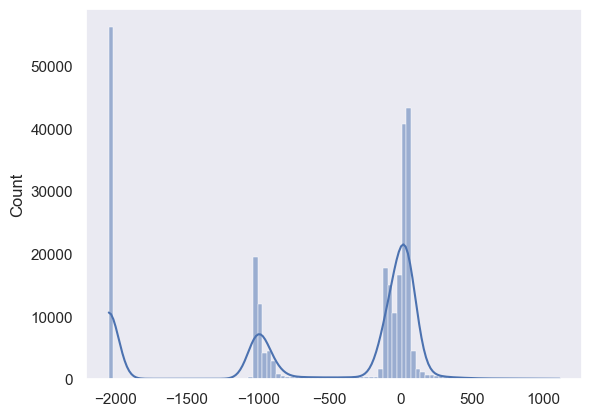

In [5]:
sns.histplot(img.flatten(), kde=True)

In [6]:
from collections import Counter
counts = Counter(img.flatten())
sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

In [7]:
sorted_counts[0:5]

[(-2048, 56252), (39, 1832), (42, 1819), (49, 1818), (46, 1815)]

In [8]:
statistic_data = img.flatten()
statistic_data = statistic_data[statistic_data > -2048]

pd.DataFrame(statistic_data).describe()

,0
count,205892.00
mean,-217.15
std,417.27
min,-1068.00
25%,-123.00
50%,-6.00
75%,40.00
max,1114.00


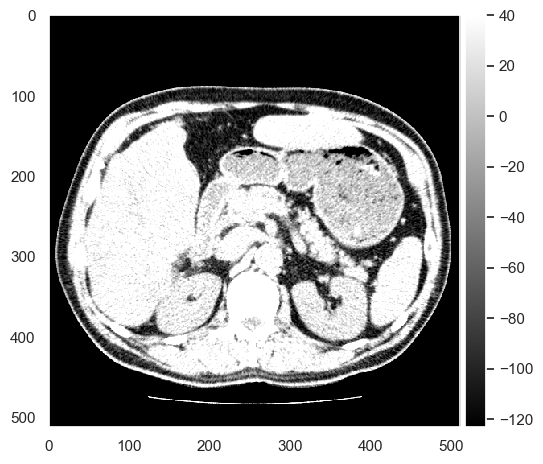

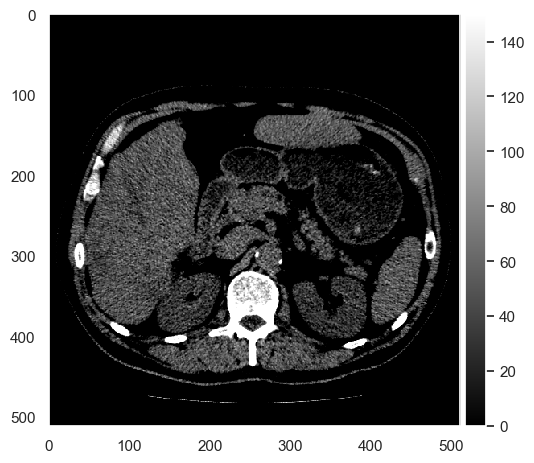

In [9]:
io.imshow(img, cmap="gray", vmin=-123, vmax=40)
io.show()
io.imshow(img, cmap="gray", vmin=0, vmax=150) #Spleen
io.show()

Shapiro-Wilk test for BoneRoi yields p-value of : 0.1380038857460022
statistic: 0.9493367671966553
Sample looks Gaussian (fail to reject H0)


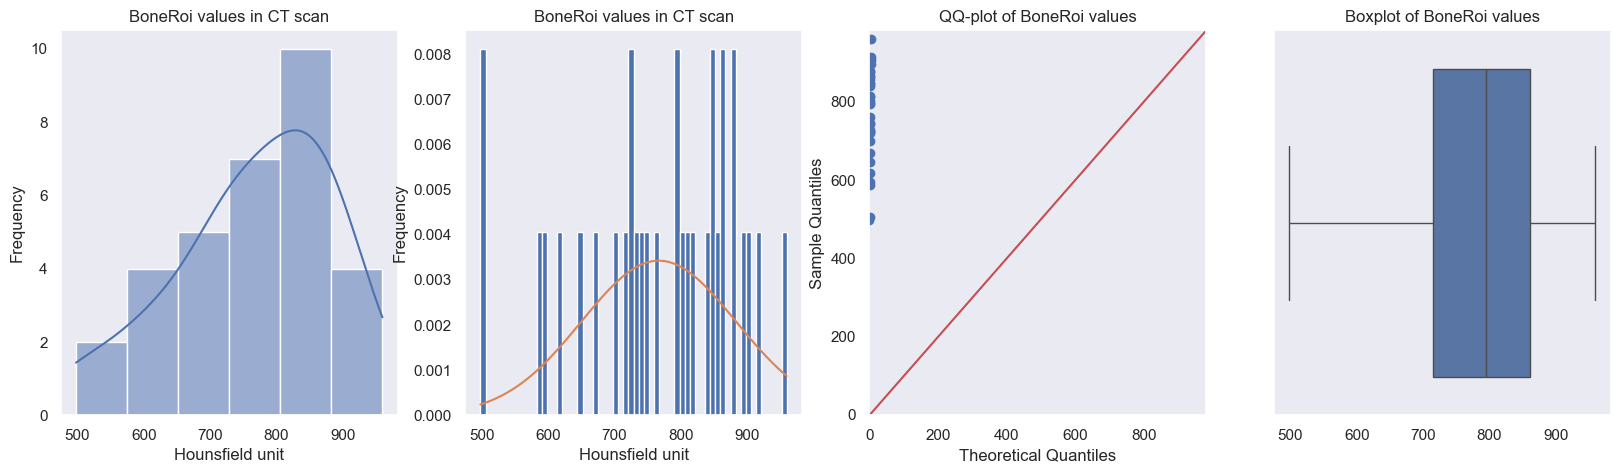

Shapiro-Wilk test for LiverROI yields p-value of : 0.00011567003093659878
statistic: 0.9973851442337036
Sample does not look Gaussian (reject H0)


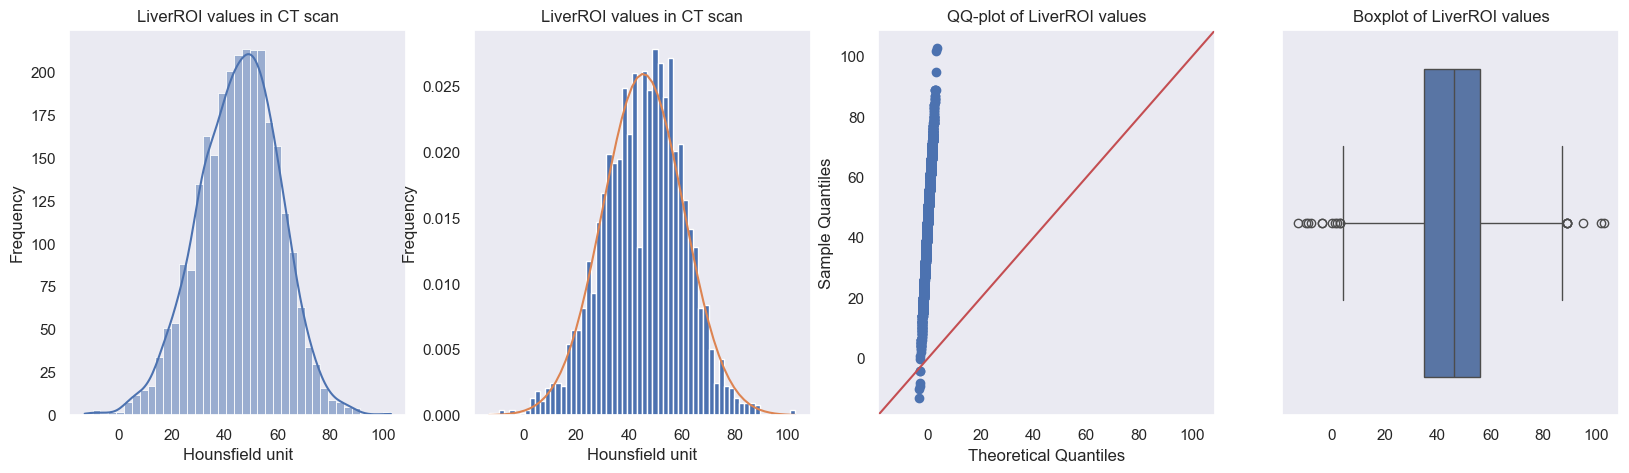

Shapiro-Wilk test for SpleenROI yields p-value of : 0.0003687610733322799
statistic: 0.9971362948417664
Sample does not look Gaussian (reject H0)


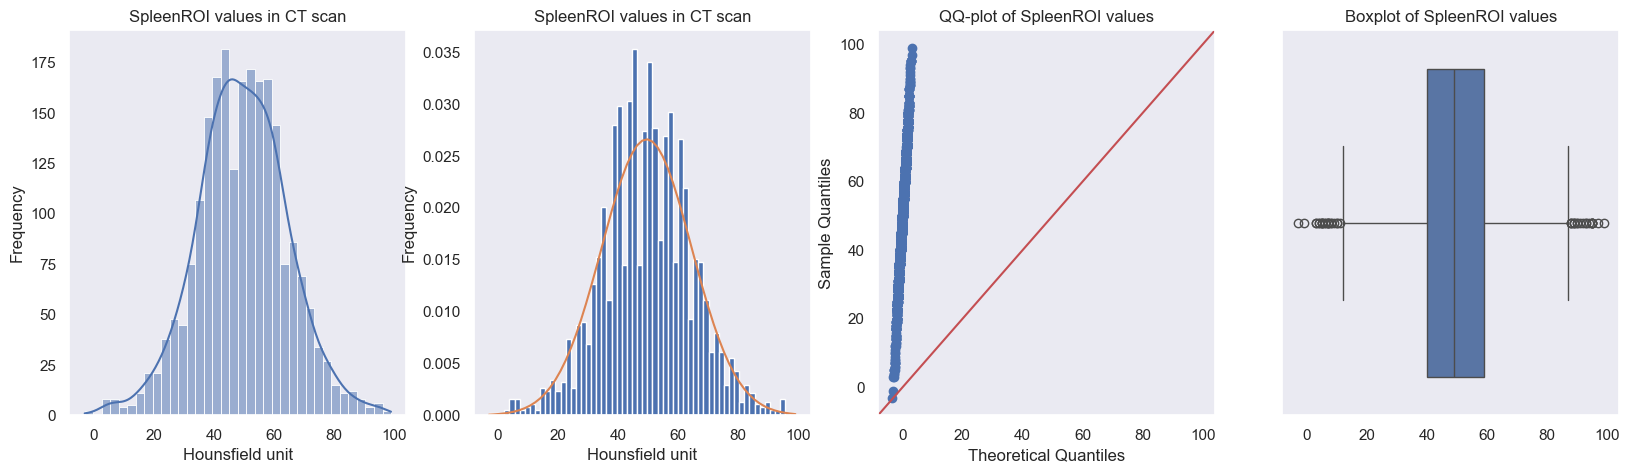

Shapiro-Wilk test for FatRoi yields p-value of : 0.11022711545228958
statistic: 0.9985170364379883
Sample looks Gaussian (fail to reject H0)


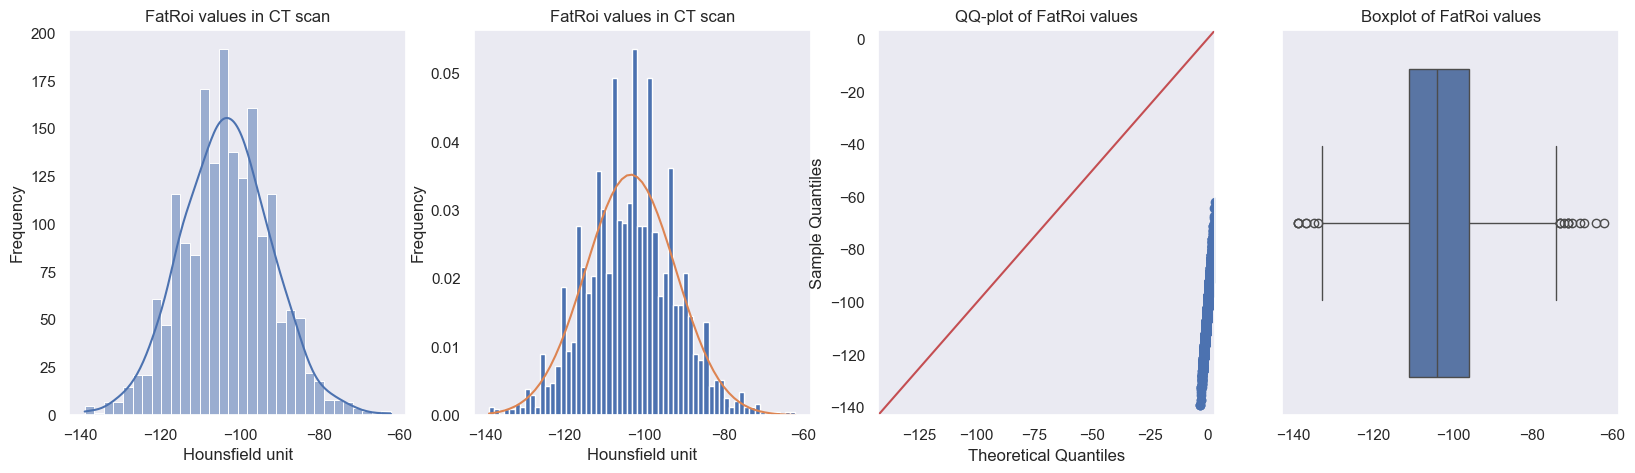

Shapiro-Wilk test for KidneyROI yields p-value of : 0.03765638917684555
statistic: 0.9978779554367065
Sample does not look Gaussian (reject H0)


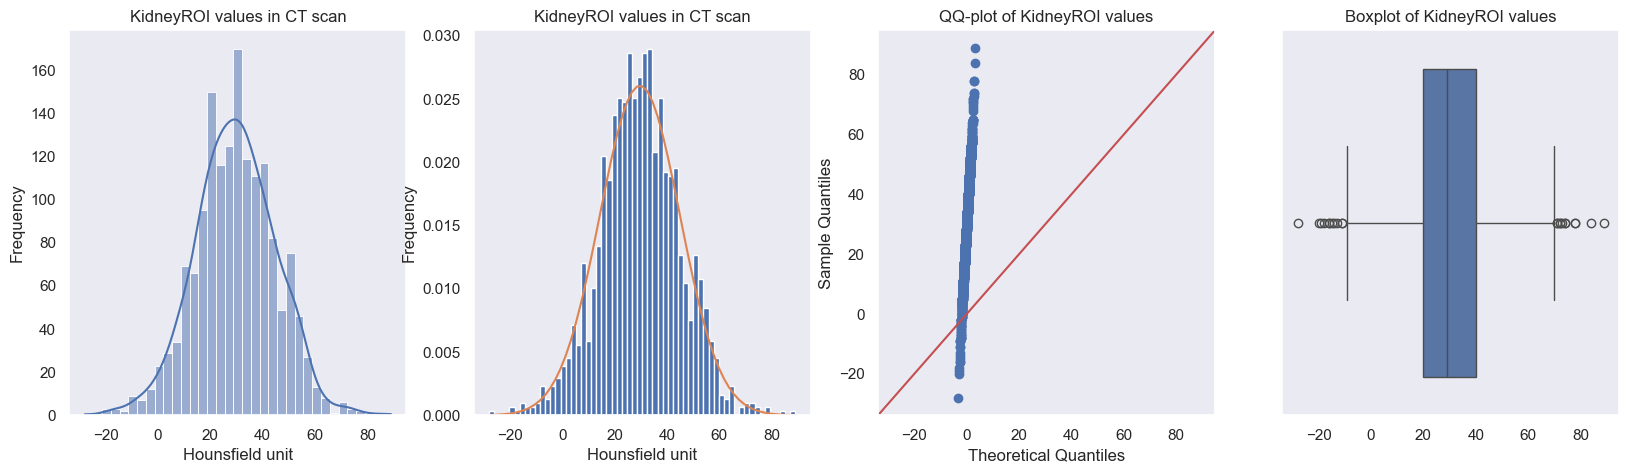

In [10]:
segments_names = ["BoneRoi.png", "LiverROI.png", "SpleenROI.png", "FatRoi.png", "KidneyROI.png"]

df_segments = pd.DataFrame(columns=["name", "pixelvalue"])
stats = []
data = {}
for filename in segments_names:
    name = filename.split(".")[0]
    segment, segment_values = get_segment(filename)
    
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    _, stat = analyse_segment(segment_values, name, ax[0])
    fitted_gaussian(segment_values, name, ax[1])
    
    QQ_plot(segment_values, name, ax[2])
    shapiro_wilk_test(segment_values, name)
    boxplot(segment_values, name, ax[3])
    
    plt.show()
    
    df_segment = pd.DataFrame(segment_values, columns=["pixelvalue"])
    df_segment["name"] = name
    
    df_segments = pd.concat([df_segments, df_segment], axis=0)
    
    stats.append(stat)
    data[name] = df_segment


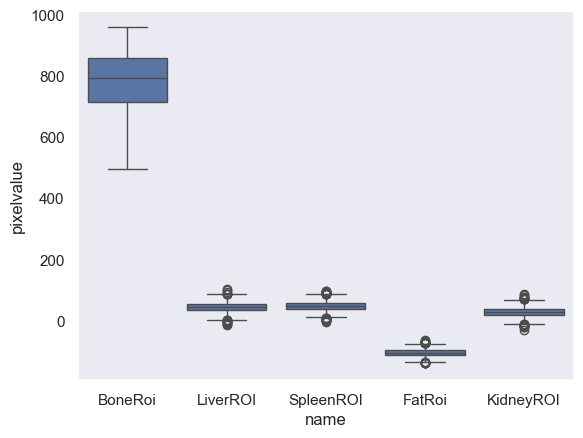

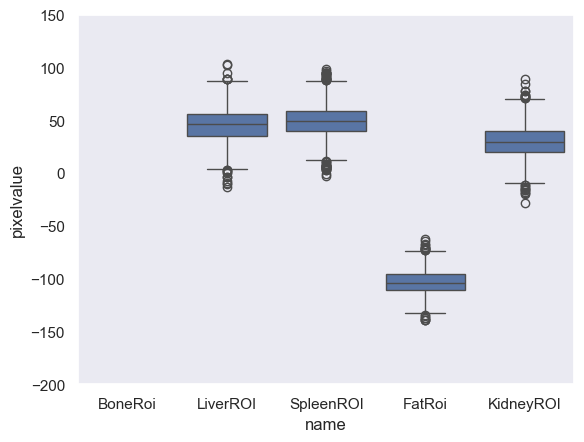

In [11]:
sns.boxplot(x="name", y="pixelvalue", data=df_segments)
plt.show()

sns.boxplot(x="name", y="pixelvalue", data=df_segments)
plt.ylim(-200, 150)
plt.show()


Since the Liver, Spleen and Kidney is overlapping in pixel values, we can barely seperate them. Therefore we can classify these 3 classes as one class. Let's call them "Organs". The Bone and Fat are easily seperated, since they don't have overlapping pixel values, so their respective classes shall remain the same. Resulting in 3 classes: Bone, Fat and Organs.

In [12]:
# 2 decimal places in output
merge_dfs(stats)


,BoneRoi,LiverROI,SpleenROI,FatRoi,KidneyROI
count,32.00,2780.00,2230.00,1829.00,1575.00
mean,766.94,45.41,49.48,-103.39,29.61
std,118.43,15.36,15.00,11.33,15.32
min,498.00,-13.00,-3.00,-139.00,-28.00
25%,715.00,35.00,40.00,-111.00,20.00
50%,795.50,46.00,49.00,-104.00,29.00
75%,860.75,56.00,59.00,-96.00,40.00
max,960.00,103.00,99.00,-62.00,89.00


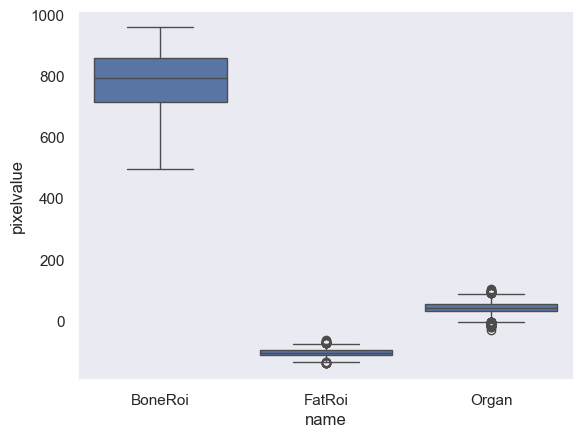

In [13]:
organs = ['LiverROI', 'SpleenROI', 'KidneyROI']
df_organs = pd.concat([data[organ] for organ in organs], axis=0)
df_organs = df_organs.reset_index(drop=True)
df_organs["name"] = "Organ"

df_bone = data["BoneRoi"]
df_fat = data["FatRoi"]

df_new_segments = pd.concat([df_bone, df_fat, df_organs], axis=0)
sns.boxplot(x="name", y="pixelvalue", data=df_new_segments)
df_classes = [df_bone, df_fat, df_organs]
for df, name in zip(df_classes, ["Bone", "Fat", "Organ"]):
    df.rename(columns={"pixelvalue": name}, inplace=True)
    
class_stats = merge_dfs([df.describe() for df in df_classes])

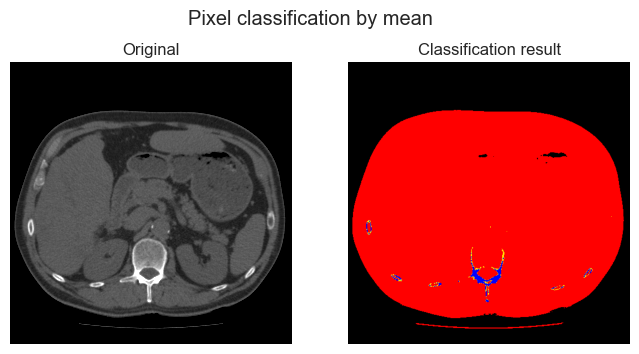

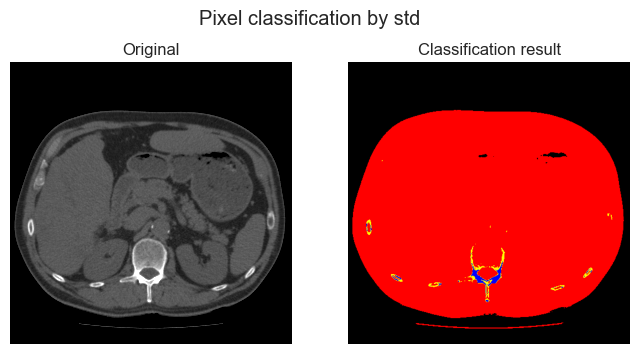

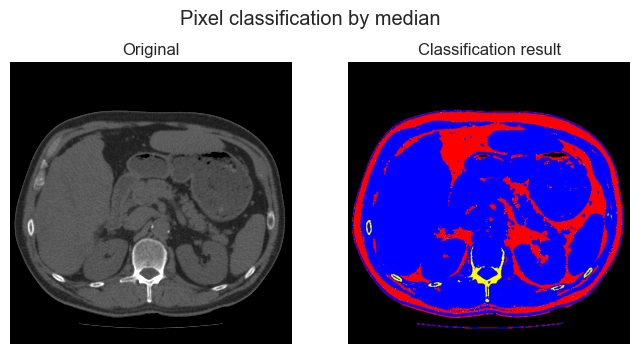

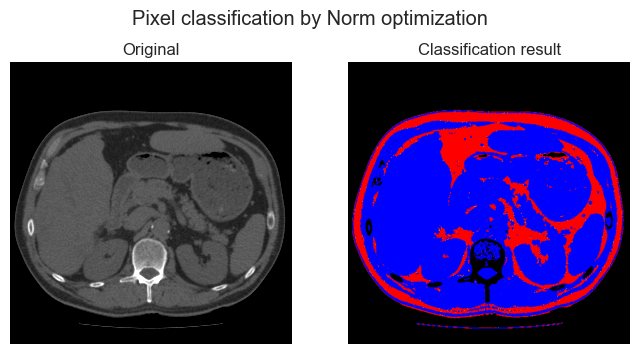

In [14]:
boundaries_mean = get_class_boundaries_by_mean(class_stats)
classify_by_boundaries(img, boundaries_mean, "Pixel classification by mean")

boundaries_std = get_class_boundaries_by_std(class_stats)
classify_by_boundaries(img, boundaries_std, "Pixel classification by std")

boundaries_median = get_class_boundaries_by_median(class_stats)
classify_by_boundaries(img, boundaries_median, "Pixel classification by median")

boundaries_norm = get_boundaries_by_norm_opt(class_stats, tqdm_disable = True)
classify_by_boundaries(img, boundaries_norm, "Pixel classification by Norm optimization")



In [15]:
def compute_blob_circularity(A : float, P : float) -> float:
    """
    Computes the circularity of a blob given A the area of the object
    and P the perimeter of the object
    A Circle has a circularity close to 1 and very-non-circular object have circularity close to 0.
    """
    return (4 * np.pi * A) / (P ** 2)

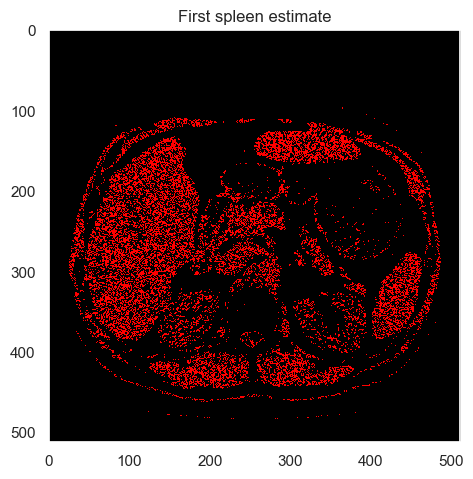

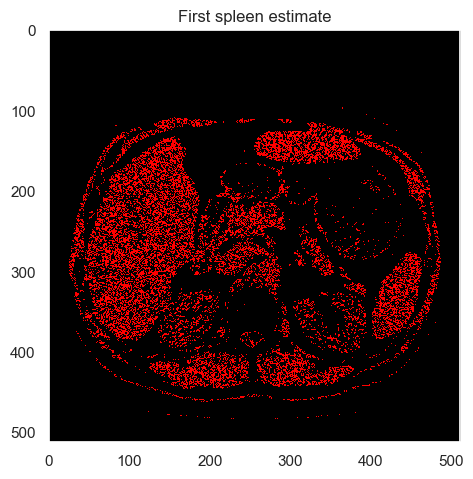

In [16]:
t_1 = 40.00
t_2 = 59.00

spleen_estimate = (img > t_1) & (img < t_2)
spleen_label_colour = color.label2rgb(spleen_estimate)
io.imshow(spleen_label_colour)
plt.title("First spleen estimate")
io.show()



spleen_estimate = (img > t_1) & (img < t_2)
spleen_label_colour = color.label2rgb(spleen_estimate)
io.imshow(spleen_label_colour)
plt.title("First spleen estimate")
io.show()

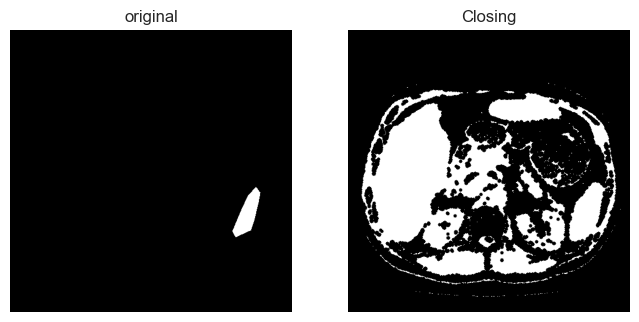

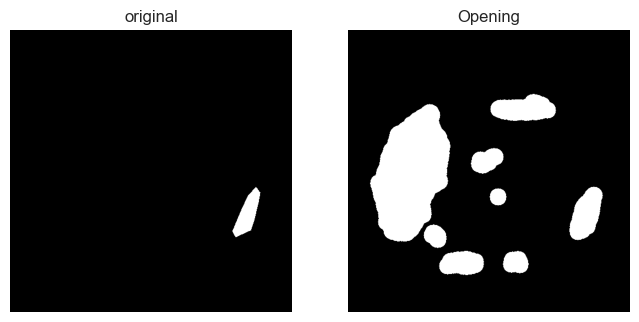

In [17]:
spleenroi = io.imread(os.path.join(BASEDIR, "SpleenROI.png"))

footprint = disk(3)
closed = binary_closing(spleen_estimate, footprint)

plot_comparison(spleenroi, closed, "Closing")

footprint = disk(15)
opened = binary_opening(closed, footprint)

plot_comparison(spleenroi, opened, "Opening")


Number of labels: 8


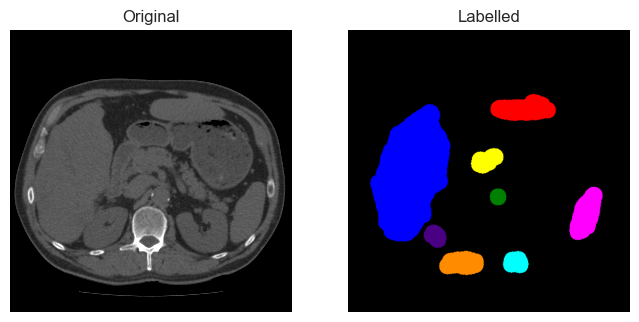

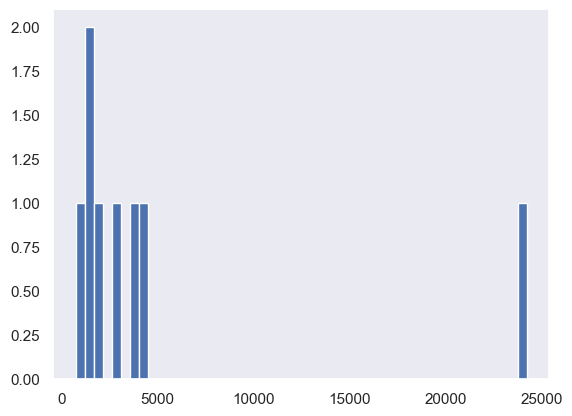

,Area [Pixels]
count,8.0
mean,5107.0
std,7823.4
min,740.0
25%,1470.0
50%,2428.0
75%,3999.5
max,24218.0


In [18]:
label_img = measure.label(opened)

n_labels = label_img.max()
print(f"Number of labels: {n_labels}")

label2rgb_img = label2rgb(label_img)
show_comparison(img, label2rgb_img, "Labelled")

region_props = measure.regionprops(label_img)
areas = np.array([prop.area for prop in region_props])
plt.hist(areas, bins=50)
plt.show()

pd.DataFrame(areas, columns=["Area [Pixels]"]).describe()



Min area:  3796.2999999999993
Max area:  17250.19999999999


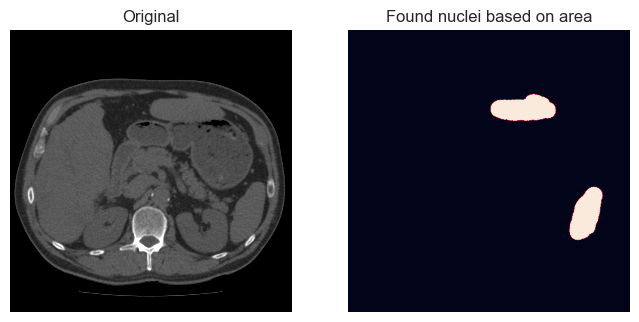

Number of labels: 2


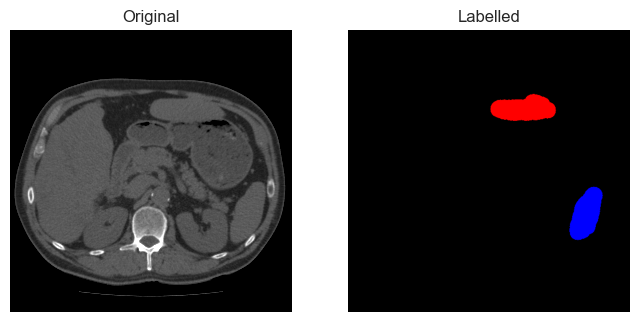

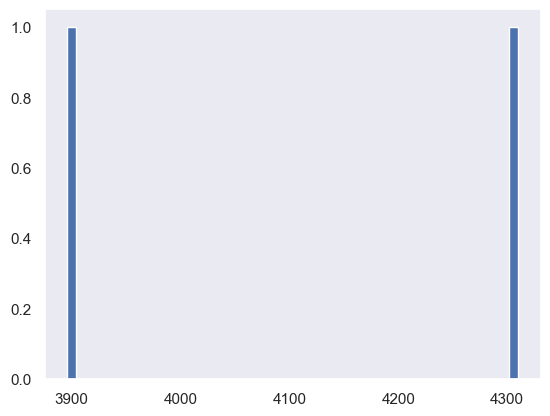

In [19]:

min_area = np.quantile(areas, 0.70)
max_area = np.quantile(areas, 0.95)

print("Min area: ", min_area)
print("Max area: ", max_area)

# Create a copy of the label_img
label_img_filter = np.copy(label_img)
for region in region_props:
	# Find the areas that do not fit our criteria
	if region.area > max_area or region.area < min_area:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0 
show_comparison(img, i_area, 'Found nuclei based on area')

label_img = measure.label(i_area)

n_labels = label_img.max()
print(f"Number of labels: {n_labels}")

label2rgb_img = label2rgb(label_img)
show_comparison(img, label2rgb_img, "Labelled")

region_props = measure.regionprops(label_img)
areas = np.array([prop.area for prop in region_props])
plt.hist(areas, bins=50)
plt.show()



Min circularity:  0.6016652403366329
Max circularity:  0.6901165926876814
Number of blobs:  1


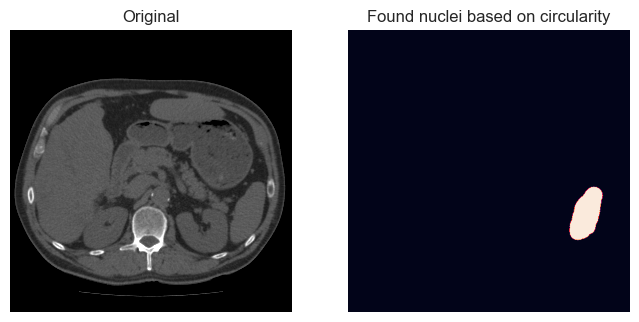

In [20]:
blob_circularities = np.array([compute_blob_circularity(prop.area, prop.perimeter) for prop in region_props])

min_circularity = np.quantile(blob_circularities, 0.25)
max_circularity = np.quantile(blob_circularities, 1)

print("Min circularity: ", min_circularity)
print("Max circularity: ", max_circularity)

# Create a copy of the label_img
label_img_filter = label_img
count = 0
for region in region_props:
    if compute_blob_circularity(region.area, region.perimeter) > max_circularity or compute_blob_circularity(region.area, region.perimeter) < min_circularity:
        # set the pixels in the invalid areas to background
        for cords in region.coords:
            label_img_filter[cords[0], cords[1]] = 0
    else:
        count += 1

print("Number of blobs: ", count)

# Create binary image from the filtered label image
i_circularity = label_img_filter > 0
show_comparison(img, i_circularity, 'Found nuclei based on circularity')


In [21]:


def dice_score(img1, img2) -> float:
    intersection = np.logical_and(img1, img2)
    # print(2*intersection.sum())
    # print(img1.sum())
    # print(img2.sum())
    return 2 * intersection.sum() / (img1.sum() + img2.sum())

dice_score(spleenroi, i_circularity)

0.7280444009141365

In [22]:
ground_truth_img = io.imread(BASEDIR + 'Validation1_spleen.png')
gt_bin = ground_truth_img > 0
dice_score = 1 - distance.dice(i_area.ravel(), gt_bin.ravel())
print(f"DICE score {dice_score}")

DICE score 0.6163350449293967


In [23]:
ground_truth_img = io.imread(BASEDIR + 'Validation2_spleen.png')
gt_bin = ground_truth_img > 0
dice_score = 1 - distance.dice(i_area.ravel(), gt_bin.ravel())
print(f"DICE score {dice_score}")

DICE score 0.5869910100475939


In [24]:
ground_truth_img = io.imread(BASEDIR + 'Validation3_spleen.png')
gt_bin = ground_truth_img > 0
dice_score = 1 - distance.dice(i_area.ravel(), gt_bin.ravel())
print(f"DICE score {dice_score}")

DICE score 0.5814596250093373
